In [1]:
from oct_Utils import *
from pandarallel import pandarallel
pandarallel.initialize()

Duplicate key in file PosixPath('/home/octusr3/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 260 ('font.family:  sans-serif')
Duplicate key in file PosixPath('/home/octusr3/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 268 ('font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')
Duplicate key in file PosixPath('/home/octusr3/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 411 ('axes.unicode_minus: True  # use Unicode for the minus symbol rather than hyphen.  See')
/home/octusr3/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


INFO: Pandarallel will run on 96 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
df = pd.read_csv('/home/octusr2/projects/data_fast/csv/0901.csv')
df = df[['image_path', 'source', 'pid', 'dates', 'eye', 'pos', 'num', 'pd_prob']]
print_df(df)

['image_path', 'source', 'pid', 'dates', 'eye', 'pos', 'num', 'pd_prob']
26453


,image_path,source,pid,dates,eye,pos,num,pd_prob
0,20210730-中山眼科-OCT转VF/CASIA数据汇总-new/CRC-009-143...,CASIA数据汇总-new,CRC-009-143,2018-06-26,OS,disc,[[ 0 0 0 0 0 0 0 0 0 0]\n [ 0 0 0 2...,[[0 0 0 0 0 0 0 0 0 0]\n [0 0 0 1 1 1 1 0 0 0]...
...,...,...,...,...,...,...,...,...
26452,20210820-sysu-oct/MAGIC4/MAGIC2242/20210713/OS...,MAGIC4,MAGIC2242,2021-07-13,OS,macula,[[ 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [...,[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]\n [0. 0. 0. 3...


[[False False False False False False False False False False]
 [False False False  True  True  True  True False False False]
 [False False  True  True  True  True  True  True False False]
 [False  True  True  True  True  True  True  True  True False]
 [ True  True  True  True  True  True  True False  True False]
 [ True  True  True  True  True  True  True False  True False]
 [False  True  True  True  True  True  True  True  True False]
 [False False  True  True  True  True  True  True False False]
 [False False False  True  True  True  True False False False]
 [False False False False False False False False False False]]


/home/octusr3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/home/octusr3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


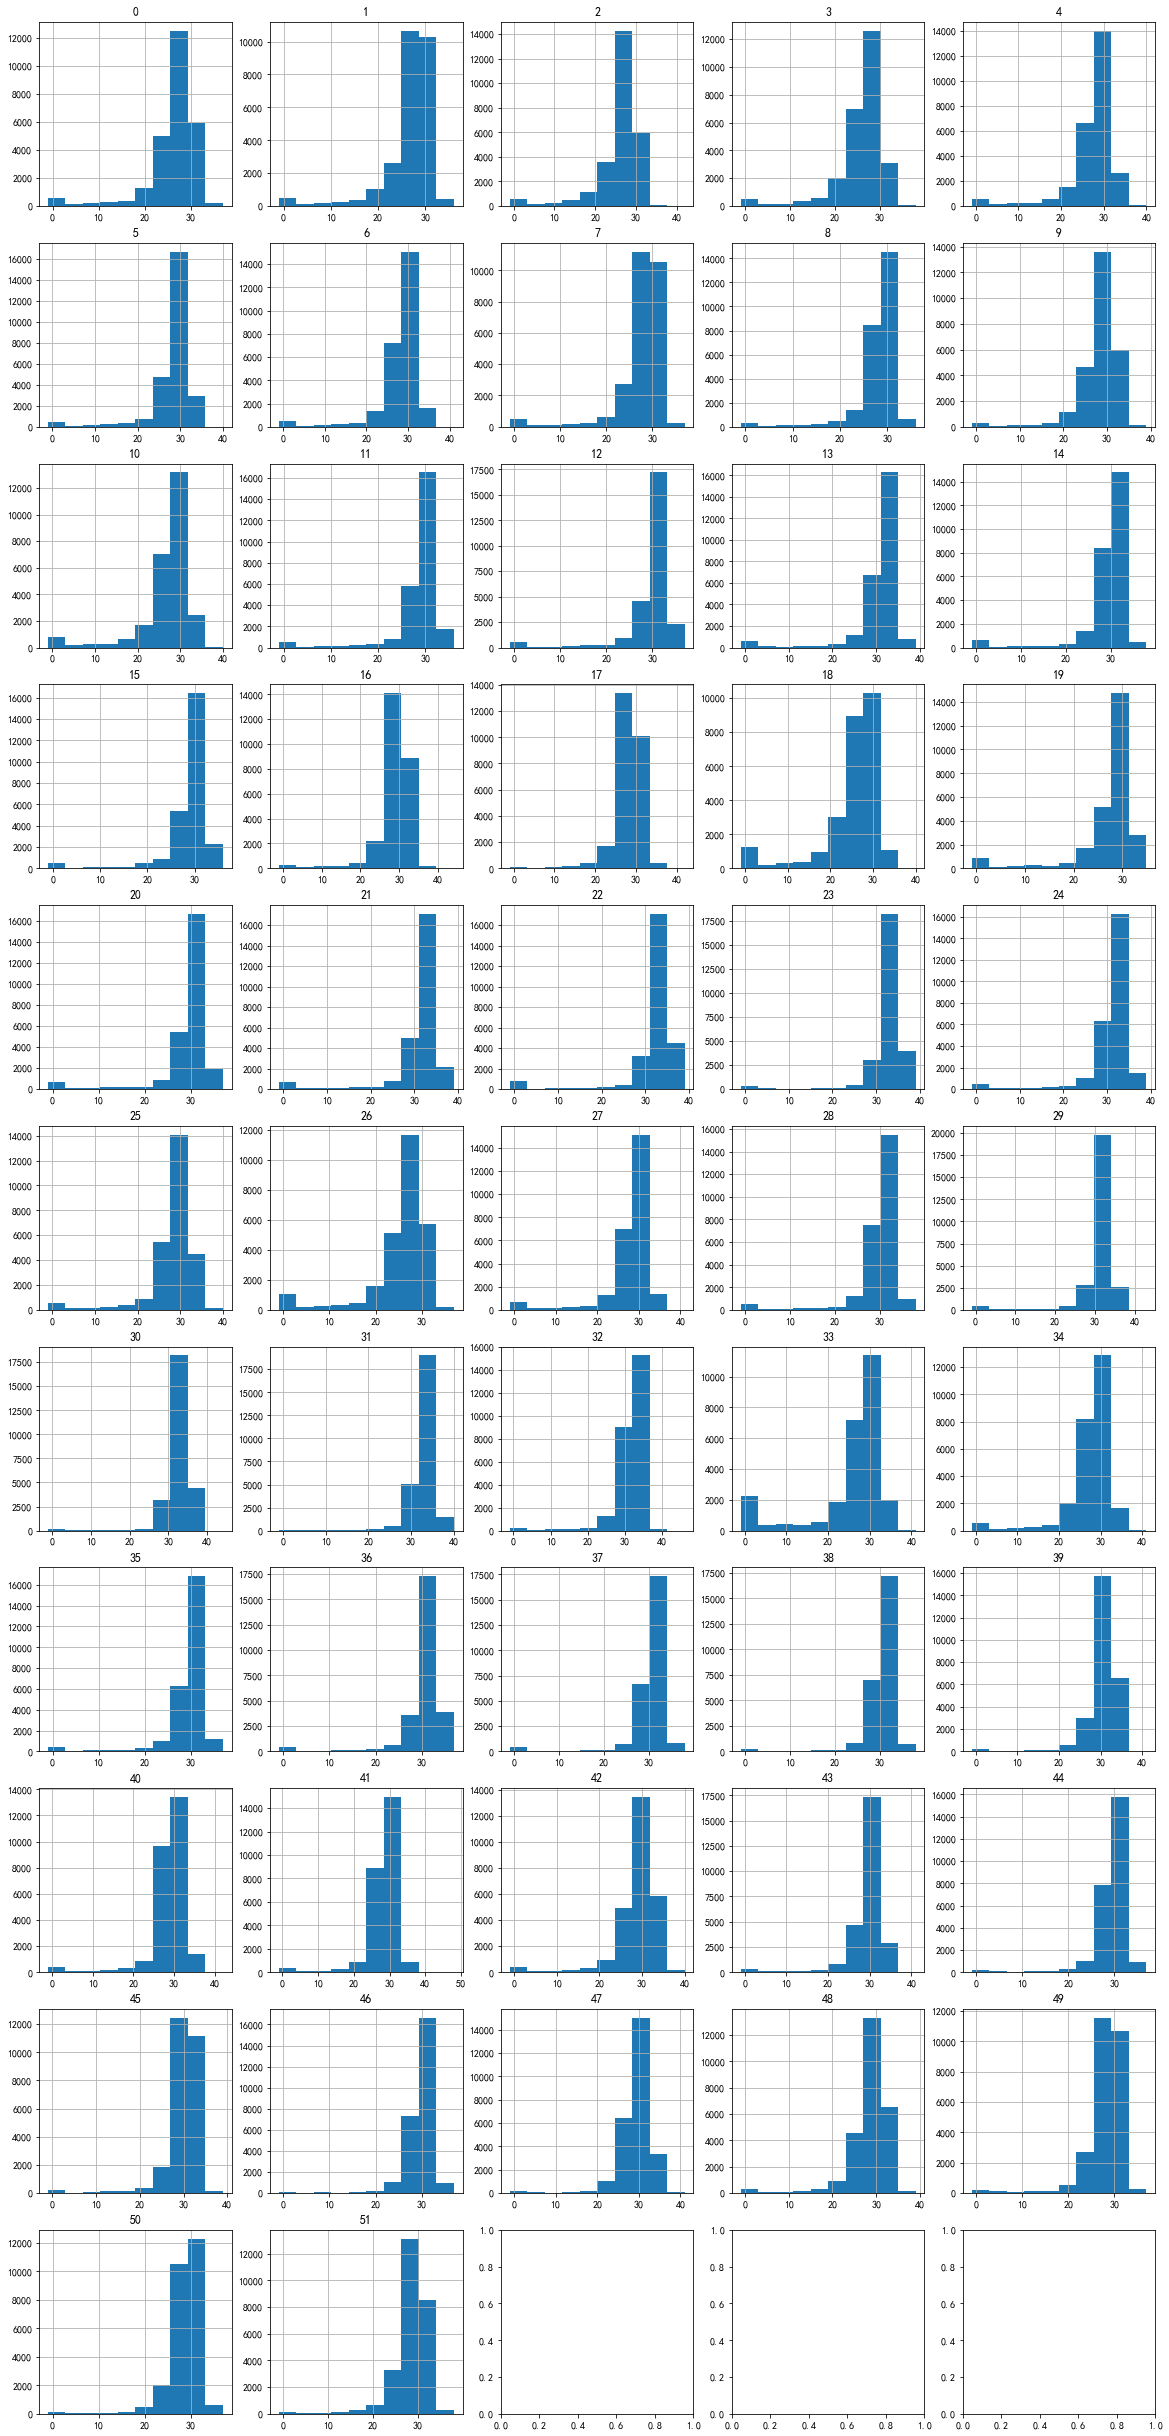

In [3]:
valid_mask = '''
[[0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 1 1 1 0 0 0]
[0 0 1 1 1 1 1 1 0 0]
[0 1 1 1 1 1 1 1 1 0]
[1 1 1 1 1 1 1 0 1 0]
[1 1 1 1 1 1 1 0 1 0]
[0 1 1 1 1 1 1 1 1 0]
[0 0 1 1 1 1 1 1 0 0]
[0 0 0 1 1 1 1 0 0 0]
[0 0 0 0 0 0 0 0 0 0]]'''
valid_mask = str_to_np_mat(valid_mask.strip(), dtype=int) == 1
print(valid_mask)

df_stat = df.copy()

def read_label(row, col):
    mat = str_to_np_mat(row[col], dtype=float)
    eye = row['eye']
    if eye == 'OS':
        mat = np.flip(mat, axis=1)
    result = mat[valid_mask]
    return result

df_stat['np_num'] = df_stat.parallel_apply(partial(read_label, col='num'), axis=1)
df_stat['np_pd_prob'] = df_stat.parallel_apply(partial(read_label, col='pd_prob'), axis=1)#这个东西可以用来替换apply用其他参数的args,直接用偏函数更为简洁漂亮

n_fig = 52
n_row = -(-n_fig // 5)
fig, axs = plt.subplots(n_row, 5, figsize=(20, n_row * 4))
for i in range(52):
    df[f'label_num_{i}_reg'] = df_stat['np_num'].map(lambda x: x[i])
    df[f'label_pd_prob_{i}'] = df_stat['np_pd_prob'].map(lambda x: 0 if int(x[i]) == 1 else 1)
    
    ax = axs.ravel()[i]
    df[f'label_num_{i}_reg'].astype(float).hist(ax=ax)
    ax.set_title(i)
    
plt.show()
plt.close(fig)

In [4]:
vc(df['eye'])
vc(df['pos'])

{'OD': 13353, 'OS': 13100}
{'disc': 13392, 'macula': 13061}


In [5]:
label_info = {
    'label_cols': [], 
    'n_classes': [], 
    'mean_std': []
}

for col in filter(lambda x: x.startswith('label_'), df.columns):
    label_info['label_cols'].append(col)
    if col.endswith('_reg'):
        label_info['n_classes'].append(1)
        label_info['mean_std'].append((df[col].mean(), df[col].std(ddof=0)))
        df[col] = (df[col] - df[col].mean()) / df[col].std(ddof=0)
    else:
        label_info['n_classes'].append(df[col].nunique())
        label_info['mean_std'].append((0, 0))
        

In [6]:
id_base = 'pid'
date = '1230'
label_type = 'num'

for model, size, pos in product(['r50'], ['512'], ['disc', 'macula']):
    exp_name = f'{date}/{pos}_{label_type}_{model}_{size}'
    df_tmp = df.copy()
    df_tmp = df_tmp[df_tmp['pos'] == pos]
    df_tmp['dataset'] = df_tmp[id_base].map(to_dataset_mapping(df_tmp[id_base].tolist(), 5))
    ensure_path(f'output/{exp_name}/exp-{id_base}/tasks')
    json_dump(label_info, f'output/{exp_name}/exp-{id_base}/tasks/label_info.json')
    df_tmp.to_csv(f'output/{exp_name}/exp-{id_base}/tasks/data.csv', index=False)